<a href="https://colab.research.google.com/github/FED32/Fire_detection/blob/main/%22Fire_detection_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет
https://github.com/cair/Fire-Detection-Image-Dataset.git

Еще датасет
https://www.kaggle.com/datasets/phylake1337/fire-dataset

Статья
https://habr.com/ru/company/nix/blog/441620/

Еще статья
https://habr.com/ru/post/598617/

Пример моей учебной работы по дообучению сети VGG16
https://www.kaggle.com/code/fed9211/my-cats-vs-dogs

Документация keras
https://keras.io/api/

Документация resnet
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

In [ ]:
import numpy as np
import pandas as pd

import cv2
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf.__version__)
print(tf.executing_eagerly())

import os
from random import shuffle
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

2.8.0
True


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# загружаем картинки
fire_images = glob('gdrive/MyDrive/Fire_detecting/data/dataset/Fire images 1/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Fire images 2/*.png')

normal_images = glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 1/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 2/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 3/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 4/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 5/*.jpg') + \
glob('gdrive/MyDrive/Fire_detecting/data/dataset/Normal Images 6/*.png')

shuffle(fire_images)
shuffle(normal_images)

print(f'Количество картинок с пожаром', len(fire_images))
print(f'Количество обычных картинок', len(normal_images))

Количество картинок с пожаром 860
Количество обычных картинок 761


In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
# функция для отображения картинок
def show_images(files):
    fig = plt.figure(figsize=(16, 8))
    for i, path in enumerate(files[:10], 1):
        subplot = fig.add_subplot(2, 5, i)
        subplot.set_title('%s' % path.split('/')[-1])
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        plt.imshow(img)
    return None

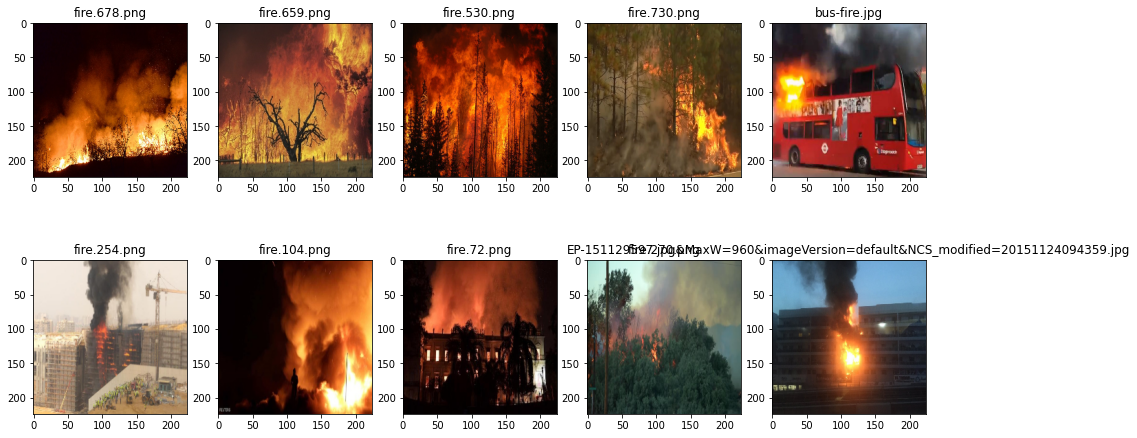

In [ ]:
show_images(fire_images)

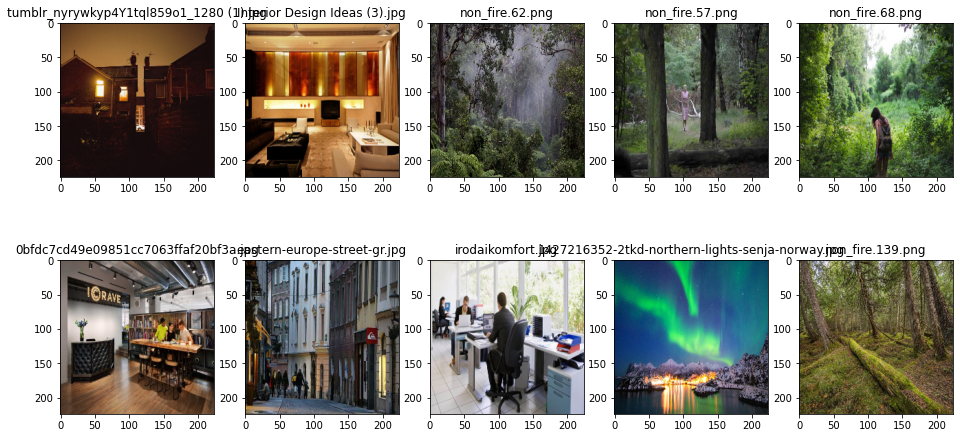

In [ ]:
show_images(normal_images)

In [ ]:
# функция для загрузки и предобработки изображения
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return resnet50.preprocess_input(img, data_format=None)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if os.path.dirname(path).split('/')[-1].startswith('Fire') else 0
                          for path in files[i:j]])
            yield (x, y)
            
            
# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
# разбиваем данные на тренировочные и тестовые
def get_train_test(files):
    train = files[:round(len(files)*0.8)]
    test = files[round(len(files)*0.8):]
    return train, test

train_files = get_train_test(fire_images)[0] + get_train_test(normal_images)[0]
test_files = get_train_test(fire_images)[1] + get_train_test(normal_images)[1]

shuffle(train_files)
shuffle(test_files)

print(f'Тренировочных изображений', len(train_files))
print(f'Тестовых изображений', len(test_files))

Тренировочных изображений 1297
Тестовых изображений 324


In [ ]:
# загружаем базовую модель
# base_model - объект класса keras.models.Model (Functional Model)
base_model = resnet50.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
# x = tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='fire_detector')

In [ ]:
model.summary()

Model: "fire_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                      

In [ ]:
# компилируем модель
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [ ]:
# настраиваем чекпоинты
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='acc', min_delta=0.001,
                           patience=10, verbose=1, mode='auto')
chkpt = ModelCheckpoint('fire_detector.hdf5', 
                        monitor='loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')
callbacks = [early_stop, chkpt]

In [ ]:
# формируем тренировочные и валидационные данные
val_samples = 5  # число изображений в валидационной выборке
epochs=100

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

In [ ]:
# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=epochs,  # число эпох обучения
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8969WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: loss improved from inf to 0.35736, saving model to fire_detector.hdf5
10/10 [==============================] - 71s 6s/step - loss: 0.3574 - accuracy: 0.8969 - val_loss: 1.5532 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.9406WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: loss improved from 0.35736 to 0.34624, saving model to fire_detector.hdf5
10/10 [==============================] - 74s 8s/step - loss: 0.3462 - accuracy: 0.9406 - val_loss: 0.0541 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.9563WARNIN

In [ ]:
# сохраняем модель
model.save('gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5')

In [ ]:
# model.load_weights('gdrive/MyDrive/Fire_detecting/models/fire-datector-resnet50.hdf5')

In [ ]:
# предсказываем класс тестовых картинок
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files), verbose=1)

324/324 [==============================] - 85s 259ms/step


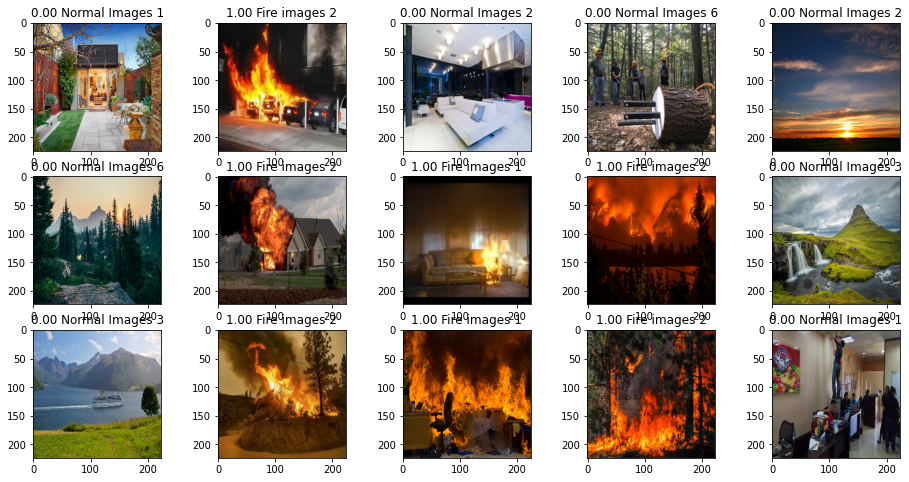

In [ ]:
# визуализируем предсказания
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:15], test_pred[:15]), 1):
    subplot = fig.add_subplot(3, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.dirname(path).split('/')[-1]))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

fig.savefig('gdrive/MyDrive/Fire_detecting/predict')

In [ ]:
# валидация на тренировочных данных
score = model.evaluate(fit_generator(train_files), verbose=1, steps=len(train_files))
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

1297/1297 [==============================] - 1337s 1s/step - loss: 0.1118 - accuracy: 0.9992
Validation loss: 0.11181634664535522
Validation accuracy: 0.9992048740386963


In [ ]:
# валидация на тестовых данных
score = model.evaluate(fit_generator(test_files), verbose=1, steps=len(test_files))
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

324/324 [==============================] - 383s 1s/step - loss: 0.4369 - accuracy: 0.9755
Validation loss: 0.43686628341674805
Validation accuracy: 0.975501537322998


In [ ]:
# посторение confusion matrix
labels = np.array([1 if os.path.dirname(path).split('/')[-1].startswith('Fire') else 0 for path in test_files])
con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.around(test_pred)).numpy()
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat, index = [0,1], columns = [0,1])

In [ ]:
con_mat_df

,0,1
0,71,81
1,81,91


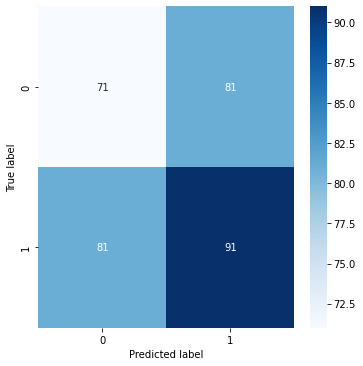

In [ ]:
# визуализация confusion matrix
figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# формируем датасет с результатами и сохраняем в файл csv
ids = []
folder = []
prob = []
for path, score in zip(test_files, np.around(test_pred)):
    ids.append((os.path.basename(path)))
    folder.append((os.path.dirname(path).split('/')[-1]))
    prob.append(score[0])

In [ ]:
output = pd.DataFrame({'id': ids, 'folder': folder, 'label': prob})
output.to_csv('gdrive/MyDrive/Fire_detecting/submission.csv', index=False)

In [ ]:
output.head(20)

,id,folder,label
0,AdvisoryCouncilMeeting477x318.jpg,Normal Images 1,0.0
1,fire.90.png,Fire images 2,1.0
2,fire.295.png,Fire images 2,0.0
3,non_fire.105.png,Normal Images 6,0.0
4,Late_model_Ford_Model_T.jpg,Normal Images 3,0.0
5,non_fire.238.png,Normal Images 6,0.0
6,fire.220.png,Fire images 2,1.0
7,fire.56.png,Fire images 2,1.0
8,fire.154.png,Fire images 2,1.0
9,burning-charcoal-briquettes.jpg,Fire images 1,0.0
